In [1]:
import xml.etree.ElementTree as ET
import csv

from classes.xml import values
from classes.vector3 import Vector3
from classes.quaternion import Quaternion
from classes.metamodel import Hull, Weapon, Link, MobileObject, WeaponWithMobileObjects, Cannon, WeaponWithCannons
from classes.mutation import mutate_model

# 1. Dataset construction

In [2]:
path_in = "models/"
objects = ["Argos", "Orion", "Teuthus", "Vermis"]

nodes = {"ObjectData": 0, "PhysicalObjectData": 1, "AliveObjectData": 2, "ComponentData": 3, "LinkData": 0, "WeaponCannonData": 0}

path_out = "results/"
datasets = {}

## 1.1. Aggregation relationships (5)

### 1.1.1 Hull
### 1.1.2 Weapon
### 1.1.3 Link
### 1.1.4 AIUnit
### 1.1.5 MovementAI

In [3]:
# 1.1.1. Hull.

'''
1st step: Parsing of XML models.
'''

dataset = []

for o in objects:
    xml = ET.parse(f"{path_in}{o}.xml").getroot()

    print(f"###### Working with {o}.xml #######")

    ### Hulls ###
    hulls = xml.findall("HULL/Hull")
    print(f"\nNo. of 'HULL/Hull': %d\n" % len(hulls))

    if len(hulls) > 0:
        hull_types = list(map(int, [hull.get("HullType") for hull in hulls]))
        print(f"HullTypes: {hull_types}\n")
        
        # ObjectData
        scales_x = values(hulls, nodes["ObjectData"], "ScaleX")
        scales_y = values(hulls, nodes["ObjectData"], "ScaleY")
        scales_z = values(hulls, nodes["ObjectData"], "ScaleZ")
        scales = [Vector3(scales_x[i], scales_y[i], scales_z[i]) for i in range(len(hulls))]
        print(f"Scales: {scales}\n")

        positions_x = values(hulls, nodes["ObjectData"], "PositionX")
        positions_y = values(hulls, nodes["ObjectData"], "PositionY")
        positions_z = values(hulls, nodes["ObjectData"], "PositionZ")
        positions = [Vector3(positions_x[i], positions_y[i], positions_z[i]) for i in range(len(hulls))]
        print(f"Positions: {positions}\n")

        orientations_w = values(hulls, nodes["ObjectData"], "OrientationW")
        orientations_x = values(hulls, nodes["ObjectData"], "OrientationX")
        orientations_y = values(hulls, nodes["ObjectData"], "OrientationY")
        orientations_z = values(hulls, nodes["ObjectData"], "OrientationZ")
        orientations = [Quaternion(orientations_w[i], orientations_x[i], orientations_y[i], orientations_z[i]) for i in range(len(hulls))]
        print(f"Orientations: {orientations}\n")

        # PhysicalObjectData
        object_masses = list(map(float, values(hulls, nodes["PhysicalObjectData"], "ObjectMass")))
        print(f"ObjectMasses: {object_masses}\n")

        object_materials = list(map(int, values(hulls, nodes["PhysicalObjectData"], "ObjectMaterial")))
        print(f"ObjectMaterials: {object_materials}\n")

        # AliveObjectData
        object_maximum_lifes = list(map(float, values(hulls, nodes["AliveObjectData"], "ObjectMaximumLife")))
        print(f"ObjectMaximumLifes: {object_maximum_lifes}\n")

        object_armors = list(map(float, values(hulls, nodes["AliveObjectData"], "ObjectArmor")))
        print(f"ObjectArmors: {object_armors}\n")

        destruction_delays = list(map(float, values(hulls, nodes["AliveObjectData"], "DestructionDelay")))
        print(f"DestructionDelays: {destruction_delays}\n")

        effect_multipliers_kill = list(map(float, values(hulls, nodes["AliveObjectData"], "EffectMultiplierKill")))
        print(f"EffectMultipliersKill: {effect_multipliers_kill}\n")

        effect_multipliers_destroy = list(map(float, values(hulls, nodes["AliveObjectData"], "EffectMultiplierDestroy")))
        print(f"EffectMultipliersDestroy: {effect_multipliers_destroy}\n")

        effects_masks_kill = values(hulls, nodes["AliveObjectData"], "EffectsMaskKill")
        print(f"EffectsMasksKill: {effects_masks_kill}\n")

        effects_masks_destroy = values(hulls, nodes["AliveObjectData"], "EffectsMaskDestroy")
        print(f"EffectsMasksDestroy: {effects_masks_destroy}\n")

        # ComponentData
        hull_index_parents = list(map(int, values(hulls, nodes["ComponentData"], "HullIndexParent")))
        print(f"HullIndexParents: {hull_index_parents}\n")

        local_directions_x = values(hulls, nodes["ComponentData"], "LocalDirectionX")
        local_directions_y = values(hulls, nodes["ComponentData"], "LocalDirectionY")
        local_directions_z = values(hulls, nodes["ComponentData"], "LocalDirectionZ")
        local_directions = [Vector3(local_directions_x[i], local_directions_y[i], local_directions_z[i]) for i in range(len(hulls))]
        print(f"LocalDirections: {local_directions}\n")

        hulls_ = [Hull(hull_types[i],
                       scales[i], positions[i], orientations[i],
                       object_masses[i], object_materials[i],
                       object_maximum_lifes[i], object_armors[i],
                       destruction_delays[i], effect_multipliers_kill[i], effect_multipliers_destroy[i],
                       effects_masks_kill[i], effects_masks_destroy[i],
                       hull_index_parents[i], local_directions[i])
                     for i in range(len(hulls))]

        for i in range(len(hulls)):
            dataset.append({"Name": f"{o}-baseline",
                    "HullIndexParent": hulls_[i].hull_index_parent,
                    "HullType": hulls_[i].hull_type,
                    "ScaleX": hulls_[i].scale.x,
                    "ScaleY": hulls_[i].scale.y,
                    "ScaleZ": hulls_[i].scale.z,
                    "PositionX": hulls_[i].position.x,
                    "PositionY": hulls_[i].position.y,
                    "PositionZ": hulls_[i].position.z,
                    "OrientationW": hulls_[i].orientation.w,
                    "OrientationX": hulls_[i].orientation.x,
                    "OrientationY": hulls_[i].orientation.y,
                    "OrientationZ": hulls_[i].orientation.z,
                    "ObjectMass": hulls_[i].object_mass,
                    "ObjectMaterial": hulls_[i].object_material,
                    "ObjectMaximumLife": hulls_[i].object_maximum_life,
                    "ObjectArmor": hulls_[i].object_armor,
                    "DestructionDelay": hulls_[i].destruction_delay,
                    "EffectMultiplierKill": hulls_[i].effect_multiplier_kill,
                    "EffectMultiplierDestroy": hulls_[i].effect_multiplier_destroy,
                    "EffectsMaskKill": hulls_[i].effects_mask_kill,
                    "EffectsMaskDestroy": hulls_[i].effects_mask_destroy,
                    "LocalDirectionX": hulls_[i].local_direction.x,
                    "LocalDirectionY": hulls_[i].local_direction.y,
                    "LocalDirectionZ": hulls_[i].local_direction.z,
                    "Fitness": 1})

'''
2nd step: Construction of the dataset for the chosen relation with input from all the XML models analyzed.
'''

datasets["hulls"] = dataset

'''
3rd step: Dataset persistance in a CSV format file.
'''

with open(f"{path_out}/datasets/aggregation/baseline/dataset_hulls.csv", mode='w') as file:
    fieldnames = ["Name",
                  "HullIndexParent",
                  "HullType",
                  "ScaleX",
                  "ScaleY",
                  "ScaleZ",
                  "PositionX",
                  "PositionY",
                  "PositionZ",
                  "OrientationW",
                  "OrientationX",
                  "OrientationY",
                  "OrientationZ",
                  "ObjectMass",
                  "ObjectMaterial",
                  "ObjectMaximumLife",
                  "ObjectArmor",
                  "DestructionDelay",
                  "EffectMultiplierKill",
                  "EffectMultiplierDestroy",
                  "EffectsMaskKill",
                  "EffectsMaskDestroy",
                  "LocalDirectionX",
                  "LocalDirectionY",
                  "LocalDirectionZ",
                  "Fitness"]

    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for row in dataset:
        # print(f"{row}\n")
        writer.writerow(row)



# 1.1.2. Weapon.

'''
1st step: Parsing of XML models.
'''

dataset = []

for o in objects:
    xml = ET.parse(f"{path_in}{o}.xml").getroot()
    
    print(f"###### Working with {o}.xml #######")
    
    ### Weapons ###
    weapons = xml.findall("WEAPONRYWEAPONSAI/Weapon")
    print(f"\nNo. of 'WEAPONRYWEAPONSAI/Weapon': %d\n" % len(weapons))
    
    if len(weapons) > 0:
        weapon_types = list(map(int, [weapon.get("WeaponType") for weapon in weapons]))
        print(f"WeaponTypes: {weapon_types}\n")
        
        # ObjectData
        scales_x = values(weapons, nodes["ObjectData"], "ScaleX")
        scales_y = values(weapons, nodes["ObjectData"], "ScaleY")
        scales_z = values(weapons, nodes["ObjectData"], "ScaleZ")
        scales = [Vector3(scales_x[i], scales_y[i], scales_z[i]) for i in range(len(weapons))]
        print(f"Scales: {scales}\n")

        positions_x = values(weapons, nodes["ObjectData"], "PositionX")
        positions_y = values(weapons, nodes["ObjectData"], "PositionY")
        positions_z = values(weapons, nodes["ObjectData"], "PositionZ")
        positions = [Vector3(positions_x[i], positions_y[i], positions_z[i]) for i in range(len(weapons))]
        print(f"Positions: {positions}\n")

        orientations_w = values(weapons, nodes["ObjectData"], "OrientationW")
        orientations_x = values(weapons, nodes["ObjectData"], "OrientationX")
        orientations_y = values(weapons, nodes["ObjectData"], "OrientationY")
        orientations_z = values(weapons, nodes["ObjectData"], "OrientationZ")
        orientations = [Quaternion(orientations_w[i], orientations_x[i], orientations_y[i], orientations_z[i]) for i in range(len(weapons))]
        print(f"Orientations: {orientations}\n")
        
        # PhysicalObjectData
        object_masses = list(map(float, values(weapons, nodes["PhysicalObjectData"], "ObjectMass")))
        print(f"ObjectMasses: {object_masses}\n") 
        
        object_materials = list(map(int, values(weapons, nodes["PhysicalObjectData"], "ObjectMaterial")))
        print(f"ObjectMaterials: {object_materials}\n") 
        
        # AliveObjectData
        object_maximum_lifes = list(map(float, values(weapons, nodes["AliveObjectData"], "ObjectMaximumLife")))
        print(f"ObjectMaximumLifes: {object_maximum_lifes}\n") 
        
        object_armors = list(map(float, values(weapons, nodes["AliveObjectData"], "ObjectArmor")))
        print(f"ObjectArmors: {object_armors}\n") 
        
        destruction_delays = list(map(float, values(weapons, nodes["AliveObjectData"], "DestructionDelay")))
        print(f"DestructionDelays: {destruction_delays}\n")        
        
        effect_multipliers_kill = list(map(float, values(weapons, nodes["AliveObjectData"], "EffectMultiplierKill")))
        print(f"EffectMultipliersKill: {effect_multipliers_kill}\n")
        
        effect_multipliers_destroy = list(map(float, values(weapons, nodes["AliveObjectData"], "EffectMultiplierDestroy")))
        print(f"EffectMultipliersDestroy: {effect_multipliers_destroy}\n")        
        
        effects_masks_kill = values(weapons, nodes["AliveObjectData"], "EffectsMaskKill")
        print(f"EffectsMasksKill: {effects_masks_kill}\n")        
        
        effects_masks_destroy = values(weapons, nodes["AliveObjectData"], "EffectsMaskDestroy")
        print(f"EffectsMasksDestroy: {effects_masks_destroy}\n")

        # ComponentData
        hull_index_parents = list(map(int, values(weapons, nodes["ComponentData"], "HullIndexParent")))
        print(f"HullIndexParents: {hull_index_parents}\n")

        local_directions_x = values(weapons, nodes["ComponentData"], "LocalDirectionX")
        local_directions_y = values(weapons, nodes["ComponentData"], "LocalDirectionY")
        local_directions_z = values(weapons, nodes["ComponentData"], "LocalDirectionZ")
        local_directions = [Vector3(local_directions_x[i], local_directions_y[i], local_directions_z[i]) for i in range(len(weapons))]
        print(f"LocalDirections: {local_directions}\n")
        
        # WeaponData
        weapons_data = xml.findall("WEAPONRYWEAPONSAI/Weapon/WeaponData")
        
        weapon_priorities = list(map(int,   [weapon_data.get("WeaponPriority") for weapon_data in weapons_data]))
        weapon_behaviours = list(map(int,   [weapon_data.get("WeaponBehaviour") for weapon_data in weapons_data]))
        reload_times      = list(map(float, [weapon_data.get("ReloadTime") for weapon_data in weapons_data]))
        has_locks         = list(map(int,   [weapon_data.get("HasLock") for weapon_data in weapons_data]))
        
        affector_types         = list(map(int,   [weapon_data.get("AffectorType") for weapon_data in weapons_data]))
        affector_scale_factors = list(map(float, [weapon_data.get("AffectorScaleFactor") for weapon_data in weapons_data]))
        affector_power_factors = list(map(float, [weapon_data.get("AffectorPowerFactor") for weapon_data in weapons_data]))
        
        affector_positions_x = list(map(float, [weapon_data.get("AffectorPositionX") for weapon_data in weapons_data]))
        affector_positions_y = list(map(float, [weapon_data.get("AffectorPositionY") for weapon_data in weapons_data]))
        affector_positions_z = list(map(float, [weapon_data.get("AffectorPositionZ") for weapon_data in weapons_data]))
        affector_positions = [Vector3(affector_positions_x[i], affector_positions_y[i], affector_positions_z[i]) for i in range(len(weapons))]

        weapons_ = [Weapon(weapon_types[i],
                           scales[i], positions[i], orientations[i],
                           object_masses[i], object_materials[i],
                           object_maximum_lifes[i], object_armors[i],
                           destruction_delays[i], effect_multipliers_kill[i], effect_multipliers_destroy[i],
                           effects_masks_kill[i], effects_masks_destroy[i],
                           hull_index_parents[i], local_directions[i],
                           weapon_priorities[i], weapon_behaviours[i], reload_times[i], has_locks[i],
                           affector_types[i], affector_scale_factors[i], affector_power_factors[i], affector_positions[i])
                     for i in range(len(weapons))]
        
        for i in range(len(weapons)):
            dataset.append({"Name": f"{o}-baseline",
                    "HullIndexParent": weapons_[i].hull_index_parent,
                    "WeaponType": weapons_[i].weapon_type,
                    "ScaleX": weapons_[i].scale.x,
                    "ScaleY": weapons_[i].scale.y,
                    "ScaleZ": weapons_[i].scale.z,
                    "PositionX": weapons_[i].position.x,
                    "PositionY": weapons_[i].position.y,
                    "PositionZ": weapons_[i].position.z,
                    "OrientationW": weapons_[i].orientation.w,
                    "OrientationX": weapons_[i].orientation.x,
                    "OrientationY": weapons_[i].orientation.y,
                    "OrientationZ": weapons_[i].orientation.z,
                    "ObjectMass": weapons_[i].object_mass,
                    "ObjectMaterial": weapons_[i].object_material,
                    "ObjectMaximumLife": weapons_[i].object_maximum_life,
                    "ObjectArmor": weapons_[i].object_armor,
                    "DestructionDelay": weapons_[i].destruction_delay,
                    "EffectMultiplierKill": weapons_[i].effect_multiplier_kill,
                    "EffectMultiplierDestroy": weapons_[i].effect_multiplier_destroy,
                    "EffectsMaskKill": weapons_[i].effects_mask_kill,
                    "EffectsMaskDestroy": weapons_[i].effects_mask_destroy,
                    "LocalDirectionX": weapons_[i].local_direction.x,
                    "LocalDirectionY": weapons_[i].local_direction.y,
                    "LocalDirectionZ": weapons_[i].local_direction.z,
                    "WeaponPriority": weapons_[i].weapon_priority,
                    "WeaponBehaviour": weapons_[i].weapon_behaviour,
                    "ReloadTime": weapons_[i].reload_time,
                    "HasLock": weapons_[i].has_lock,
                    "AffectorType": weapons_[i].affector_type,
                    "AffectorScaleFactor": weapons_[i].affector_scale_factor,
                    "AffectorPowerFactor": weapons_[i].affector_power_factor,
                    "AffectorPositionX": weapons_[i].affector_position.x,
                    "AffectorPositionY": weapons_[i].affector_position.y,
                    "AffectorPositionZ": weapons_[i].affector_position.z,
                    "Fitness": 1})

'''
2nd step: Construction of the dataset for the chosen relation with input from all the XML models analyzed.
'''

datasets["weapons"] = dataset

'''
3rd step: Dataset persistance in a CSV format file.
'''

with open(f"{path_out}/datasets/aggregation/baseline/dataset_weapons.csv", mode='w') as file:
    fieldnames = ["Name",
                  "HullIndexParent",
                  "WeaponType",
                  "ScaleX",
                  "ScaleY",
                  "ScaleZ",
                  "PositionX",
                  "PositionY",
                  "PositionZ",
                  "OrientationW",
                  "OrientationX",
                  "OrientationY",
                  "OrientationZ",
                  "ObjectMass",
                  "ObjectMaterial",
                  "ObjectMaximumLife",
                  "ObjectArmor",
                  "DestructionDelay",
                  "EffectMultiplierKill",
                  "EffectMultiplierDestroy",
                  "EffectsMaskKill",
                  "EffectsMaskDestroy",
                  "LocalDirectionX",
                  "LocalDirectionY",
                  "LocalDirectionZ",
                  "WeaponPriority",
                  "WeaponBehaviour",
                  "ReloadTime",
                  "HasLock",
                  "AffectorType",
                  "AffectorScaleFactor",
                  "AffectorPowerFactor",
                  "AffectorPositionX",
                  "AffectorPositionY",
                  "AffectorPositionZ",
                  "Fitness"]

    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for row in dataset:
        # print(f"{row}\n")
        writer.writerow(row)



# 1.1.3. Link.

'''
1st step: Parsing of XML models.
'''

dataset = []

for o in objects:
    xml = ET.parse(f"{path_in}{o}.xml").getroot()
    
    print(f"###### Working with {o}.xml #######")
    
    ### Links ###
    links = xml.findall("HULL/LINKS/Link")
    print(f"\nNo. of 'HULL/LINKS/Link': %d\n" % len(links))
    
    if len(links) > 0:
        link_types = list(map(int, [link.get("LinkType") for link in links]))
        print(f"LinkTypes: {link_types}\n")
        
        hulls_index_first = list(map(int, values(links, nodes["LinkData"], "HullIndexFirst")))
        print(f"HullsIndexFirst: {hulls_index_first}\n")
        
        hulls_index_second = list(map(int, values(links, nodes["LinkData"], "HullIndexSecond")))
        print(f"HullsIndexSecond: {hulls_index_second}\n")        
        
        destructibles = list(map(int, values(links, nodes["LinkData"], "Destructible")))
        print(f"Destructibles: {destructibles}\n")        
        
        destruction_delays = list(map(float, values(links, nodes["LinkData"], "DestructionDelay")))
        print(f"DestructionDelays: {destruction_delays}\n")        
        
        effect_multipliers_kill = list(map(float, values(links, nodes["LinkData"], "EffectMultiplierKill")))
        print(f"EffectMultipliersKill: {effect_multipliers_kill}\n")
        
        effect_multipliers_destroy = list(map(float, values(links, nodes["LinkData"], "EffectMultiplierDestroy")))
        print(f"EffectMultipliersDestroy: {effect_multipliers_destroy}\n")        
        
        effects_masks_kill = values(links, nodes["LinkData"], "EffectsMaskKill")
        print(f"EffectsMasksKill: {effects_masks_kill}\n")        
        
        effects_masks_destroy = values(links, nodes["LinkData"], "EffectsMaskDestroy")
        print(f"EffectsMasksDestroy: {effects_masks_destroy}\n")
    
        links_ = [Link(link_types[i], hulls_index_first[i], hulls_index_second[i],
                       destructibles[i], destruction_delays[i],
                       effect_multipliers_kill[i], effect_multipliers_destroy[i],
                       effects_masks_kill[i], effects_masks_destroy[i])
                  for i in range(len(links))]
        
        for i in range(len(links)):
            dataset.append({"Name": f"{o}-baseline",
                    "LinkType": links_[i].link_type,
                    "HullIndexFirst": links_[i].hull_index_first,
                    "HullIndexSecond": links_[i].hull_index_second,
                    "Destructible": links_[i].destructible,
                    "DestructionDelay": links_[i].destruction_delay,
                    "EffectMultiplierKill": links_[i].effect_multiplier_kill,
                    "EffectMultiplierDestroy": links_[i].effect_multiplier_destroy,
                    "EffectsMaskKill": links_[i].effects_mask_kill,
                    "EffectsMaskDestroy": links_[i].effects_mask_destroy,
                    "Fitness": 1})

'''
2nd step: Construction of the dataset for the chosen relation with input from all the XML models analyzed.
'''

datasets["links"] = dataset

'''
3rd step: Dataset persistance in a CSV format file.
'''

with open(f"{path_out}/datasets/aggregation/baseline/dataset_links.csv", mode='w') as file:
    fieldnames = ["Name",
                  "LinkType",
                  "HullIndexFirst",
                  "HullIndexSecond",
                  "Destructible",
                  "DestructionDelay",
                  "EffectMultiplierKill",
                  "EffectMultiplierDestroy",
                  "EffectsMaskKill",
                  "EffectsMaskDestroy",
                  "Fitness"]

    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for row in dataset:
        # print(f"{row}\n")
        writer.writerow(row)



# 1.1.4. AIUnit.

'''
1st step: Parsing of XML models.
'''

dataset = []

for o in objects:
    xml = ET.parse(f"{path_in}{o}.xml").getroot()
    
    print(f"###### Working with {o}.xml #######")
    
    ### AIUnit ###
    ai_units = xml.findall("AIUNIT")
    print(f"\nNo. of 'AIUNIT': %d\n" % len(ai_units))
    
    if len(ai_units) > 0:
        unit_value = list(map(int, [elem.get("UnitValue") for elem in ai_units]))[0]
        print(f"UnitValues: {unit_value}\n")

        behaviour_unit_ai_data = xml.findall("AIUNIT/BehaviourUnitAIData")
        print(f"\nNo. of 'AIUNIT/BehaviourUnitAIData': %d\n" % len(behaviour_unit_ai_data))

        behaviour_unit_ai_data_ = [elem.attrib for elem in behaviour_unit_ai_data]
        print(behaviour_unit_ai_data_)

        for i in range(len(behaviour_unit_ai_data_)):
            dataset += [{"Name": f"{o}-baseline", "UnitValue": unit_value, **behaviour_unit_ai_data_[i]}]
            dataset[i]["Fitness"] = 1

'''
2nd step: Construction of the dataset for the chosen relation with input from all the XML models analyzed.
'''

datasets["ai_units"] = dataset

'''
3rd step: Dataset persistance in a CSV format file.
'''

with open(f"{path_out}/datasets/aggregation/baseline/dataset_ai_units.csv", mode='w') as file:
    fieldnames = ["Name", "UnitValue"] + list(behaviour_unit_ai_data_[0].keys()) + ["Fitness"]

    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for row in dataset:
        # print(f"{row}\n")
        writer.writerow(row)



# 1.1.5. MovementAI.

'''
1st step: Parsing of XML models.
'''

dataset = []

for i, o in enumerate(objects):
    xml = ET.parse(f"{path_in}{o}.xml").getroot()
    
    print(f"###### Working with {o}.xml #######")
    
    ### MovementAI ###
    ai_movements = xml.findall("MOVEMENTAI")
    print(f"\nNo. of 'MOVEMENTAI': %d\n" % len(ai_movements))
    
    if len(ai_movements) > 0:
        movement_ai_ = {}
        for elem in ai_movements:
            for node in elem.iter():
                movement_ai_.update(node.attrib)
        print(movement_ai_)

        dataset += [{"Name": f"{o}-baseline", **movement_ai_}]
        dataset[i]["Fitness"] = 1

'''
2nd step: Construction of the dataset for the chosen relation with input from all the XML models analyzed.
'''

datasets["ai_movements"] = dataset

'''
3rd step: Dataset persistance in a CSV format file.
'''

with open(f"{path_out}/datasets/aggregation/baseline/dataset_ai_movements.csv", mode='w') as file:
    fieldnames = ["Name"] + list(movement_ai_.keys()) + ["Fitness"]

    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for row in dataset:
        # print(f"{row}\n")
        writer.writerow(row)

###### Working with Argos.xml #######

No. of 'HULL/Hull': 36

HullTypes: [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Scales: [Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.

## 1.2. Association relationships (4)

### 1.2.1. Link-HullIndexFirst-Hull
### 1.2.2. Link-HullIndexSecond-Hull
### 1.2.3. Weapon-MobileObject
### 1.2.4. Weapon-Cannon

In [4]:
# 1.2.1. Link-HullIndexFirst-Hull.

'''
1st step: Parsing of XML models.
'''

dataset = []

for i, o in enumerate(objects):
    xml = ET.parse(f"{path_in}{o}.xml").getroot()

    print(f"###### Working with {o}.xml #######")

    ## Hulls ##
    hulls = xml.findall("HULL/Hull")
    print(f"\nNo. of 'HULL/Hull': %d\n" % len(hulls))

    if len(hulls) > 0:
        hull_types = list(map(int, [hull.get("HullType") for hull in hulls]))
        print(f"HullTypes: {hull_types}\n")
        
        # ObjectData
        scales_x = values(hulls, nodes["ObjectData"], "ScaleX")
        scales_y = values(hulls, nodes["ObjectData"], "ScaleY")
        scales_z = values(hulls, nodes["ObjectData"], "ScaleZ")
        scales = [Vector3(scales_x[i], scales_y[i], scales_z[i]) for i in range(len(hulls))]
        print(f"Scales: {scales}\n")

        positions_x = values(hulls, nodes["ObjectData"], "PositionX")
        positions_y = values(hulls, nodes["ObjectData"], "PositionY")
        positions_z = values(hulls, nodes["ObjectData"], "PositionZ")
        positions = [Vector3(positions_x[i], positions_y[i], positions_z[i]) for i in range(len(hulls))]
        print(f"Positions: {positions}\n")

        orientations_w = values(hulls, nodes["ObjectData"], "OrientationW")
        orientations_x = values(hulls, nodes["ObjectData"], "OrientationX")
        orientations_y = values(hulls, nodes["ObjectData"], "OrientationY")
        orientations_z = values(hulls, nodes["ObjectData"], "OrientationZ")
        orientations = [Quaternion(orientations_w[i], orientations_x[i], orientations_y[i], orientations_z[i]) for i in range(len(hulls))]
        print(f"Orientations: {orientations}\n")

        # PhysicalObjectData
        object_masses = list(map(float, values(hulls, nodes["PhysicalObjectData"], "ObjectMass")))
        print(f"ObjectMasses: {object_masses}\n")

        object_materials = list(map(int, values(hulls, nodes["PhysicalObjectData"], "ObjectMaterial")))
        print(f"ObjectMaterials: {object_materials}\n")

        # AliveObjectData
        object_maximum_lifes = list(map(float, values(hulls, nodes["AliveObjectData"], "ObjectMaximumLife")))
        print(f"ObjectMaximumLifes: {object_maximum_lifes}\n")

        object_armors = list(map(float, values(hulls, nodes["AliveObjectData"], "ObjectArmor")))
        print(f"ObjectArmors: {object_armors}\n")

        destruction_delays = list(map(float, values(hulls, nodes["AliveObjectData"], "DestructionDelay")))
        print(f"DestructionDelays: {destruction_delays}\n")

        effect_multipliers_kill = list(map(float, values(hulls, nodes["AliveObjectData"], "EffectMultiplierKill")))
        print(f"EffectMultipliersKill: {effect_multipliers_kill}\n")

        effect_multipliers_destroy = list(map(float, values(hulls, nodes["AliveObjectData"], "EffectMultiplierDestroy")))
        print(f"EffectMultipliersDestroy: {effect_multipliers_destroy}\n")

        effects_masks_kill = values(hulls, nodes["AliveObjectData"], "EffectsMaskKill")
        print(f"EffectsMasksKill: {effects_masks_kill}\n")

        effects_masks_destroy = values(hulls, nodes["AliveObjectData"], "EffectsMaskDestroy")
        print(f"EffectsMasksDestroy: {effects_masks_destroy}\n")

        # ComponentData
        hull_index_parents = list(map(int, values(hulls, nodes["ComponentData"], "HullIndexParent")))
        print(f"HullIndexParents: {hull_index_parents}\n")

        local_directions_x = values(hulls, nodes["ComponentData"], "LocalDirectionX")
        local_directions_y = values(hulls, nodes["ComponentData"], "LocalDirectionY")
        local_directions_z = values(hulls, nodes["ComponentData"], "LocalDirectionZ")
        local_directions = [Vector3(local_directions_x[i], local_directions_y[i], local_directions_z[i]) for i in range(len(hulls))]
        print(f"LocalDirections: {local_directions}\n")

        hulls_ = [Hull(hull_types[i],
                       scales[i], positions[i], orientations[i],
                       object_masses[i], object_materials[i],
                       object_maximum_lifes[i], object_armors[i],
                       destruction_delays[i], effect_multipliers_kill[i], effect_multipliers_destroy[i],
                       effects_masks_kill[i], effects_masks_destroy[i],
                       hull_index_parents[i], local_directions[i])
                     for i in range(len(hulls))]
        
    ### Links ###
    links = xml.findall("HULL/LINKS/Link")
    print(f"\nNo. of 'HULL/LINKS/Link': %d\n" % len(links))
    
    if len(links) > 0:
        link_types = list(map(int, [link.get("LinkType") for link in links]))
        print(f"LinkTypes: {link_types}\n")
        
        hulls_index_first = list(map(int, values(links, nodes["LinkData"], "HullIndexFirst")))
        print(f"HullsIndexFirst: {hulls_index_first}\n")
        
        hulls_index_second = list(map(int, values(links, nodes["LinkData"], "HullIndexSecond")))
        print(f"HullsIndexSecond: {hulls_index_second}\n")        
        
        destructibles = list(map(int, values(links, nodes["LinkData"], "Destructible")))
        print(f"Destructibles: {destructibles}\n")        
        
        destruction_delays = list(map(float, values(links, nodes["LinkData"], "DestructionDelay")))
        print(f"DestructionDelays: {destruction_delays}\n")        
        
        effect_multipliers_kill = list(map(float, values(links, nodes["LinkData"], "EffectMultiplierKill")))
        print(f"EffectMultipliersKill: {effect_multipliers_kill}\n")
        
        effect_multipliers_destroy = list(map(float, values(links, nodes["LinkData"], "EffectMultiplierDestroy")))
        print(f"EffectMultipliersDestroy: {effect_multipliers_destroy}\n")        
        
        effects_masks_kill = values(links, nodes["LinkData"], "EffectsMaskKill")
        print(f"EffectsMasksKill: {effects_masks_kill}\n")        
        
        effects_masks_destroy = values(links, nodes["LinkData"], "EffectsMaskDestroy")
        print(f"EffectsMasksDestroy: {effects_masks_destroy}\n")
    
        links_ = [Link(link_types[i], hulls_index_first[i], hulls_index_second[i],
                       destructibles[i], destruction_delays[i],
                       effect_multipliers_kill[i], effect_multipliers_destroy[i],
                       effects_masks_kill[i], effects_masks_destroy[i])
                  for i in range(len(links))]
        
        for i in range(len(links)):
            hull_index_first = int(links_[i].hull_index_first)
            
            dataset.append({"Name": f"{o}-baseline",
                    "LinkType": links_[i].link_type,
                    "Destructible": links_[i].destructible,
                    "DestructionDelay": links_[i].destruction_delay,
                    "EffectMultiplierKill": links_[i].effect_multiplier_kill,
                    "EffectMultiplierDestroy": links_[i].effect_multiplier_destroy,
                    "EffectsMaskKill": links_[i].effects_mask_kill,
                    "EffectsMaskDestroy": links_[i].effects_mask_destroy,
                    "HullIndexFirst": links_[i].hull_index_first,
                    "HullType": hulls_[hull_index_first].hull_type,
                    "ScaleX": hulls_[hull_index_first].scale.x,
                    "ScaleY": hulls_[hull_index_first].scale.y,
                    "ScaleZ": hulls_[hull_index_first].scale.z,
                    "PositionX": hulls_[hull_index_first].position.x,
                    "PositionY": hulls_[hull_index_first].position.y,
                    "PositionZ": hulls_[hull_index_first].position.z,
                    "OrientationW": hulls_[hull_index_first].orientation.w,
                    "OrientationX": hulls_[hull_index_first].orientation.x,
                    "OrientationY": hulls_[hull_index_first].orientation.y,
                    "OrientationZ": hulls_[hull_index_first].orientation.z,
                    "ObjectMass": hulls_[hull_index_first].object_mass,
                    "ObjectMaterial": hulls_[hull_index_first].object_material,
                    "ObjectMaximumLife": hulls_[hull_index_first].object_maximum_life,
                    "ObjectArmor": hulls_[hull_index_first].object_armor,
                    "DestructionDelay": hulls_[hull_index_first].destruction_delay,
                    "EffectMultiplierKill": hulls_[hull_index_first].effect_multiplier_kill,
                    "EffectMultiplierDestroy": hulls_[hull_index_first].effect_multiplier_destroy,
                    "EffectsMaskKill": hulls_[hull_index_first].effects_mask_kill,
                    "EffectsMaskDestroy": hulls_[hull_index_first].effects_mask_destroy,
                    "LocalDirectionX": hulls_[hull_index_first].local_direction.x,
                    "LocalDirectionY": hulls_[hull_index_first].local_direction.y,
                    "LocalDirectionZ": hulls_[hull_index_first].local_direction.z,
                    "Fitness": 1})

'''
2nd step: Construction of the dataset for the chosen relation with input from all the XML models analyzed.
'''

datasets["links_hif_hull"] = dataset

'''
3rd step: Dataset persistance in a CSV format file.
'''

with open(f"{path_out}/datasets/association/baseline/dataset_links_hif_hull.csv", mode='w') as file:
    fieldnames = ["Name",
                  "LinkType",
                  "Destructible",
                  "DestructionDelay",
                  "EffectMultiplierKill",
                  "EffectMultiplierDestroy",
                  "EffectsMaskKill",
                  "EffectsMaskDestroy",
                  "HullIndexFirst",
                  "HullType",
                  "ScaleX",
                  "ScaleY",
                  "ScaleZ",
                  "PositionX",
                  "PositionY",
                  "PositionZ",
                  "OrientationW",
                  "OrientationX",
                  "OrientationY",
                  "OrientationZ",
                  "ObjectMass",
                  "ObjectMaterial",
                  "ObjectMaximumLife",
                  "ObjectArmor",
                  "DestructionDelay",
                  "EffectMultiplierKill",
                  "EffectMultiplierDestroy",
                  "EffectsMaskKill",
                  "EffectsMaskDestroy",
                  "LocalDirectionX",
                  "LocalDirectionY",
                  "LocalDirectionZ",
                  "Fitness"]

    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for row in dataset:
        # print(f"{row}\n")
        writer.writerow(row)



# 1.2.2. Link-HullIndexSecond-Hull.

'''
1st step: Parsing of XML models.
'''

dataset = []

for i, o in enumerate(objects):
    xml = ET.parse(f"{path_in}{o}.xml").getroot()

    print(f"###### Working with {o}.xml #######")

    ## Hulls ##
    hulls = xml.findall("HULL/Hull")
    print(f"\nNo. of 'HULL/Hull': %d\n" % len(hulls))

    if len(hulls) > 0:
        hull_types = list(map(int, [hull.get("HullType") for hull in hulls]))
        print(f"HullTypes: {hull_types}\n")
        
        # ObjectData
        scales_x = values(hulls, nodes["ObjectData"], "ScaleX")
        scales_y = values(hulls, nodes["ObjectData"], "ScaleY")
        scales_z = values(hulls, nodes["ObjectData"], "ScaleZ")
        scales = [Vector3(scales_x[i], scales_y[i], scales_z[i]) for i in range(len(hulls))]
        print(f"Scales: {scales}\n")

        positions_x = values(hulls, nodes["ObjectData"], "PositionX")
        positions_y = values(hulls, nodes["ObjectData"], "PositionY")
        positions_z = values(hulls, nodes["ObjectData"], "PositionZ")
        positions = [Vector3(positions_x[i], positions_y[i], positions_z[i]) for i in range(len(hulls))]
        print(f"Positions: {positions}\n")

        orientations_w = values(hulls, nodes["ObjectData"], "OrientationW")
        orientations_x = values(hulls, nodes["ObjectData"], "OrientationX")
        orientations_y = values(hulls, nodes["ObjectData"], "OrientationY")
        orientations_z = values(hulls, nodes["ObjectData"], "OrientationZ")
        orientations = [Quaternion(orientations_w[i], orientations_x[i], orientations_y[i], orientations_z[i]) for i in range(len(hulls))]
        print(f"Orientations: {orientations}\n")

        # PhysicalObjectData
        object_masses = list(map(float, values(hulls, nodes["PhysicalObjectData"], "ObjectMass")))
        print(f"ObjectMasses: {object_masses}\n")

        object_materials = list(map(int, values(hulls, nodes["PhysicalObjectData"], "ObjectMaterial")))
        print(f"ObjectMaterials: {object_materials}\n")

        # AliveObjectData
        object_maximum_lifes = list(map(float, values(hulls, nodes["AliveObjectData"], "ObjectMaximumLife")))
        print(f"ObjectMaximumLifes: {object_maximum_lifes}\n")

        object_armors = list(map(float, values(hulls, nodes["AliveObjectData"], "ObjectArmor")))
        print(f"ObjectArmors: {object_armors}\n")

        destruction_delays = list(map(float, values(hulls, nodes["AliveObjectData"], "DestructionDelay")))
        print(f"DestructionDelays: {destruction_delays}\n")

        effect_multipliers_kill = list(map(float, values(hulls, nodes["AliveObjectData"], "EffectMultiplierKill")))
        print(f"EffectMultipliersKill: {effect_multipliers_kill}\n")

        effect_multipliers_destroy = list(map(float, values(hulls, nodes["AliveObjectData"], "EffectMultiplierDestroy")))
        print(f"EffectMultipliersDestroy: {effect_multipliers_destroy}\n")

        effects_masks_kill = values(hulls, nodes["AliveObjectData"], "EffectsMaskKill")
        print(f"EffectsMasksKill: {effects_masks_kill}\n")

        effects_masks_destroy = values(hulls, nodes["AliveObjectData"], "EffectsMaskDestroy")
        print(f"EffectsMasksDestroy: {effects_masks_destroy}\n")

        # ComponentData
        hull_index_parents = list(map(int, values(hulls, nodes["ComponentData"], "HullIndexParent")))
        print(f"HullIndexParents: {hull_index_parents}\n")

        local_directions_x = values(hulls, nodes["ComponentData"], "LocalDirectionX")
        local_directions_y = values(hulls, nodes["ComponentData"], "LocalDirectionY")
        local_directions_z = values(hulls, nodes["ComponentData"], "LocalDirectionZ")
        local_directions = [Vector3(local_directions_x[i], local_directions_y[i], local_directions_z[i]) for i in range(len(hulls))]
        print(f"LocalDirections: {local_directions}\n")

        hulls_ = [Hull(hull_types[i],
                       scales[i], positions[i], orientations[i],
                       object_masses[i], object_materials[i],
                       object_maximum_lifes[i], object_armors[i],
                       destruction_delays[i], effect_multipliers_kill[i], effect_multipliers_destroy[i],
                       effects_masks_kill[i], effects_masks_destroy[i],
                       hull_index_parents[i], local_directions[i])
                     for i in range(len(hulls))]
        
    ### Links ###
    links = xml.findall("HULL/LINKS/Link")
    print(f"\nNo. of 'HULL/LINKS/Link': %d\n" % len(links))
    
    if len(links) > 0:
        link_types = list(map(int, [link.get("LinkType") for link in links]))
        print(f"LinkTypes: {link_types}\n")
        
        hulls_index_first = list(map(int, values(links, nodes["LinkData"], "HullIndexFirst")))
        print(f"HullsIndexFirst: {hulls_index_first}\n")
        
        hulls_index_second = list(map(int, values(links, nodes["LinkData"], "HullIndexSecond")))
        print(f"HullsIndexSecond: {hulls_index_second}\n")        
        
        destructibles = list(map(int, values(links, nodes["LinkData"], "Destructible")))
        print(f"Destructibles: {destructibles}\n")        
        
        destruction_delays = list(map(float, values(links, nodes["LinkData"], "DestructionDelay")))
        print(f"DestructionDelays: {destruction_delays}\n")        
        
        effect_multipliers_kill = list(map(float, values(links, nodes["LinkData"], "EffectMultiplierKill")))
        print(f"EffectMultipliersKill: {effect_multipliers_kill}\n")
        
        effect_multipliers_destroy = list(map(float, values(links, nodes["LinkData"], "EffectMultiplierDestroy")))
        print(f"EffectMultipliersDestroy: {effect_multipliers_destroy}\n")        
        
        effects_masks_kill = values(links, nodes["LinkData"], "EffectsMaskKill")
        print(f"EffectsMasksKill: {effects_masks_kill}\n")        
        
        effects_masks_destroy = values(links, nodes["LinkData"], "EffectsMaskDestroy")
        print(f"EffectsMasksDestroy: {effects_masks_destroy}\n")
    
        links_ = [Link(link_types[i], hulls_index_first[i], hulls_index_second[i],
                       destructibles[i], destruction_delays[i],
                       effect_multipliers_kill[i], effect_multipliers_destroy[i],
                       effects_masks_kill[i], effects_masks_destroy[i])
                  for i in range(len(links))]
        
        for i in range(len(links)):
            hull_index_second = int(links_[i].hull_index_second)
            
            dataset.append({"Name": f"{o}-baseline",
                    "LinkType": links_[i].link_type,
                    "Destructible": links_[i].destructible,
                    "DestructionDelay": links_[i].destruction_delay,
                    "EffectMultiplierKill": links_[i].effect_multiplier_kill,
                    "EffectMultiplierDestroy": links_[i].effect_multiplier_destroy,
                    "EffectsMaskKill": links_[i].effects_mask_kill,
                    "EffectsMaskDestroy": links_[i].effects_mask_destroy,
                    "HullIndexSecond": links_[i].hull_index_second,
                    "HullType": hulls_[hull_index_second].hull_type,
                    "ScaleX": hulls_[hull_index_second].scale.x,
                    "ScaleY": hulls_[hull_index_second].scale.y,
                    "ScaleZ": hulls_[hull_index_second].scale.z,
                    "PositionX": hulls_[hull_index_second].position.x,
                    "PositionY": hulls_[hull_index_second].position.y,
                    "PositionZ": hulls_[hull_index_second].position.z,
                    "OrientationW": hulls_[hull_index_second].orientation.w,
                    "OrientationX": hulls_[hull_index_second].orientation.x,
                    "OrientationY": hulls_[hull_index_second].orientation.y,
                    "OrientationZ": hulls_[hull_index_second].orientation.z,
                    "ObjectMass": hulls_[hull_index_second].object_mass,
                    "ObjectMaterial": hulls_[hull_index_second].object_material,
                    "ObjectMaximumLife": hulls_[hull_index_second].object_maximum_life,
                    "ObjectArmor": hulls_[hull_index_second].object_armor,
                    "DestructionDelay": hulls_[hull_index_second].destruction_delay,
                    "EffectMultiplierKill": hulls_[hull_index_second].effect_multiplier_kill,
                    "EffectMultiplierDestroy": hulls_[hull_index_second].effect_multiplier_destroy,
                    "EffectsMaskKill": hulls_[hull_index_second].effects_mask_kill,
                    "EffectsMaskDestroy": hulls_[hull_index_second].effects_mask_destroy,
                    "LocalDirectionX": hulls_[hull_index_second].local_direction.x,
                    "LocalDirectionY": hulls_[hull_index_second].local_direction.y,
                    "LocalDirectionZ": hulls_[hull_index_second].local_direction.z,
                    "Fitness": 1})

'''
2nd step: Construction of the dataset for the chosen relation with input from all the XML models analyzed.
'''

datasets["links_his_hull"] = dataset

'''
3rd step: Dataset persistance in a CSV format file.
'''

with open(f"{path_out}/datasets/association/baseline/dataset_links_his_hull.csv", mode='w') as file:
    fieldnames = ["Name",
                  "LinkType",
                  "Destructible",
                  "DestructionDelay",
                  "EffectMultiplierKill",
                  "EffectMultiplierDestroy",
                  "EffectsMaskKill",
                  "EffectsMaskDestroy",
                  "HullIndexSecond",
                  "HullType",
                  "ScaleX",
                  "ScaleY",
                  "ScaleZ",
                  "PositionX",
                  "PositionY",
                  "PositionZ",
                  "OrientationW",
                  "OrientationX",
                  "OrientationY",
                  "OrientationZ",
                  "ObjectMass",
                  "ObjectMaterial",
                  "ObjectMaximumLife",
                  "ObjectArmor",
                  "DestructionDelay",
                  "EffectMultiplierKill",
                  "EffectMultiplierDestroy",
                  "EffectsMaskKill",
                  "EffectsMaskDestroy",
                  "LocalDirectionX",
                  "LocalDirectionY",
                  "LocalDirectionZ",
                  "Fitness"]

    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for row in dataset:
        # print(f"{row}\n")
        writer.writerow(row)



# 1.2.3. Weapon-MobileObject.

'''
1st step: Parsing of XML models.
'''

dataset = []

for o in objects:
    xml = ET.parse(f"{path_in}{o}.xml").getroot()
    
    print(f"###### Working with {o}.xml #######")
    
    ### MobileObjects ###
    mobile_objects = xml.findall("WEAPONRYWEAPONSAI/Weapon/MobileObjects")
    print(f"\nNo. of 'WEAPONRYWEAPONSAI/Weapon/MobileObjects': %d\n" % len(mobile_objects))
    
    if len(mobile_objects) > 0:
        mobile_objects_number = list(map(int, [mobile_object.get("Number") for mobile_object in mobile_objects]))
        print(f"MobileObjectsNumber: {mobile_objects_number}\n")

        mobility_types = list(map(int, [mobile_object.get("MobilityType") for mobile_object in mobile_objects]))
        mobility_types_ = [mobility_types[no] for no, rep in enumerate(mobile_objects_number) for reps in range(rep)]
        print(f"MobilityTypes: {mobility_types_}\n")

        local_positions = [Vector3(node.attrib.get("LocalPositionX"), node.attrib.get("LocalPositionY"), node.attrib.get("LocalPositionZ")) for node in xml.findall("WEAPONRYWEAPONSAI/Weapon/MobileObjects/MobileObject")]
        local_positions_ = [local_positions[no] for no, rep in enumerate(mobile_objects_number) for reps in range(rep)]
        print(f"LocalPositions: {local_positions}\n")
        
        mobile_objects_ = [MobileObject(mobility_types_[i], local_positions_[i]) for i in range(len(xml.findall("WEAPONRYWEAPONSAI/Weapon/MobileObjects/MobileObject")))]
        print(f"{mobile_objects_}\n")
    
    ### WeaponsWithMobileObjects ###
    weapons = xml.findall("WEAPONRYWEAPONSAI/Weapon")
    weapons[:] = [weapon for weapon in weapons if weapon.find("MobileObjects") is not None]
    print(f"\nNo. of 'WEAPONRYWEAPONSAI/Weapon': %d\n" % len(weapons))
    
    if len(weapons) > 0:
        weapon_types = list(map(int, [weapon.get("WeaponType") for weapon in weapons]))
        print(f"WeaponTypes: {weapon_types}\n")
        
        # ObjectData
        scales_x = values(weapons, nodes["ObjectData"], "ScaleX")
        scales_y = values(weapons, nodes["ObjectData"], "ScaleY")
        scales_z = values(weapons, nodes["ObjectData"], "ScaleZ")
        scales = [Vector3(scales_x[i], scales_y[i], scales_z[i]) for i in range(len(weapons))]
        print(f"Scales: {scales}\n")

        positions_x = values(weapons, nodes["ObjectData"], "PositionX")
        positions_y = values(weapons, nodes["ObjectData"], "PositionY")
        positions_z = values(weapons, nodes["ObjectData"], "PositionZ")
        positions = [Vector3(positions_x[i], positions_y[i], positions_z[i]) for i in range(len(weapons))]
        print(f"Positions: {positions}\n")

        orientations_w = values(weapons, nodes["ObjectData"], "OrientationW")
        orientations_x = values(weapons, nodes["ObjectData"], "OrientationX")
        orientations_y = values(weapons, nodes["ObjectData"], "OrientationY")
        orientations_z = values(weapons, nodes["ObjectData"], "OrientationZ")
        orientations = [Quaternion(orientations_w[i], orientations_x[i], orientations_y[i], orientations_z[i]) for i in range(len(weapons))]
        print(f"Orientations: {orientations}\n")
        
        # PhysicalObjectData
        object_masses = list(map(float, values(weapons, nodes["PhysicalObjectData"], "ObjectMass")))
        print(f"ObjectMasses: {object_masses}\n") 
        
        object_materials = list(map(int, values(weapons, nodes["PhysicalObjectData"], "ObjectMaterial")))
        print(f"ObjectMaterials: {object_materials}\n") 
        
        # AliveObjectData
        object_maximum_lifes = list(map(float, values(weapons, nodes["AliveObjectData"], "ObjectMaximumLife")))
        print(f"ObjectMaximumLifes: {object_maximum_lifes}\n") 
        
        object_armors = list(map(float, values(weapons, nodes["AliveObjectData"], "ObjectArmor")))
        print(f"ObjectArmors: {object_armors}\n") 
        
        destruction_delays = list(map(float, values(weapons, nodes["AliveObjectData"], "DestructionDelay")))
        print(f"DestructionDelays: {destruction_delays}\n")        
        
        effect_multipliers_kill = list(map(float, values(weapons, nodes["AliveObjectData"], "EffectMultiplierKill")))
        print(f"EffectMultipliersKill: {effect_multipliers_kill}\n")
        
        effect_multipliers_destroy = list(map(float, values(weapons, nodes["AliveObjectData"], "EffectMultiplierDestroy")))
        print(f"EffectMultipliersDestroy: {effect_multipliers_destroy}\n")        
        
        effects_masks_kill = values(weapons, nodes["AliveObjectData"], "EffectsMaskKill")
        print(f"EffectsMasksKill: {effects_masks_kill}\n")        
        
        effects_masks_destroy = values(weapons, nodes["AliveObjectData"], "EffectsMaskDestroy")
        print(f"EffectsMasksDestroy: {effects_masks_destroy}\n")

        # ComponentData
        hull_index_parents = list(map(int, values(weapons, nodes["ComponentData"], "HullIndexParent")))
        print(f"HullIndexParents: {hull_index_parents}\n")

        local_directions_x = values(weapons, nodes["ComponentData"], "LocalDirectionX")
        local_directions_y = values(weapons, nodes["ComponentData"], "LocalDirectionY")
        local_directions_z = values(weapons, nodes["ComponentData"], "LocalDirectionZ")
        local_directions = [Vector3(local_directions_x[i], local_directions_y[i], local_directions_z[i]) for i in range(len(weapons))]
        print(f"LocalDirections: {local_directions}\n")
        
        # WeaponData
        weapons_data = xml.findall("WEAPONRYWEAPONSAI/Weapon/WeaponData")
        
        weapon_priorities = list(map(int,   [weapon_data.get("WeaponPriority") for weapon_data in weapons_data]))
        weapon_behaviours = list(map(int,   [weapon_data.get("WeaponBehaviour") for weapon_data in weapons_data]))
        reload_times      = list(map(float, [weapon_data.get("ReloadTime") for weapon_data in weapons_data]))
        has_locks         = list(map(int,   [weapon_data.get("HasLock") for weapon_data in weapons_data]))
        
        affector_types         = list(map(int,   [weapon_data.get("AffectorType") for weapon_data in weapons_data]))
        affector_scale_factors = list(map(float, [weapon_data.get("AffectorScaleFactor") for weapon_data in weapons_data]))
        affector_power_factors = list(map(float, [weapon_data.get("AffectorPowerFactor") for weapon_data in weapons_data]))
        
        affector_positions_x = list(map(float, [weapon_data.get("AffectorPositionX") for weapon_data in weapons_data]))
        affector_positions_y = list(map(float, [weapon_data.get("AffectorPositionY") for weapon_data in weapons_data]))
        affector_positions_z = list(map(float, [weapon_data.get("AffectorPositionZ") for weapon_data in weapons_data]))
        affector_positions = [Vector3(affector_positions_x[i], affector_positions_y[i], affector_positions_z[i]) for i in range(len(weapons))]
        
        k, weapons_with_mobile_objects = 0, []
        for i in range(len(mobile_objects_number)):
            mobile_objects__ = []
            for j in range(mobile_objects_number[i]):
                mobile_objects__ += [mobile_objects_[k]]
                k += 1
            weapons_with_mobile_objects += [WeaponWithMobileObjects(weapon_types[i],
                           scales[i], positions[i], orientations[i],
                           object_masses[i], object_materials[i],
                           object_maximum_lifes[i], object_armors[i],
                           destruction_delays[i], effect_multipliers_kill[i], effect_multipliers_destroy[i],
                           effects_masks_kill[i], effects_masks_destroy[i],
                           hull_index_parents[i], local_directions[i],
                           weapon_priorities[i], weapon_behaviours[i], reload_times[i], has_locks[i],
                           affector_types[i], affector_scale_factors[i], affector_power_factors[i], affector_positions[i],
                           mobile_objects__)]
        
        for i in range(len(weapons_with_mobile_objects)):
            for j in range(len(weapons_with_mobile_objects[i].mobile_objects)):
                dataset.append({"Name": f"{o}-baseline",
                                "HullIndexParent": weapons_with_mobile_objects[i].hull_index_parent,
                                "WeaponType": weapons_with_mobile_objects[i].weapon_type,
                                "ScaleX": weapons_with_mobile_objects[i].scale.x,
                                "ScaleY": weapons_with_mobile_objects[i].scale.y,
                                "ScaleZ": weapons_with_mobile_objects[i].scale.z,
                                "PositionX": weapons_with_mobile_objects[i].position.x,
                                "PositionY": weapons_with_mobile_objects[i].position.y,
                                "PositionZ": weapons_with_mobile_objects[i].position.z,
                                "OrientationW": weapons_with_mobile_objects[i].orientation.w,
                                "OrientationX": weapons_with_mobile_objects[i].orientation.x,
                                "OrientationY": weapons_with_mobile_objects[i].orientation.y,
                                "OrientationZ": weapons_with_mobile_objects[i].orientation.z,
                                "ObjectMass": weapons_with_mobile_objects[i].object_mass,
                                "ObjectMaterial": weapons_with_mobile_objects[i].object_material,
                                "ObjectMaximumLife": weapons_with_mobile_objects[i].object_maximum_life,
                                "ObjectArmor": weapons_with_mobile_objects[i].object_armor,
                                "DestructionDelay": weapons_with_mobile_objects[i].destruction_delay,
                                "EffectMultiplierKill": weapons_with_mobile_objects[i].effect_multiplier_kill,
                                "EffectMultiplierDestroy": weapons_with_mobile_objects[i].effect_multiplier_destroy,
                                "EffectsMaskKill": weapons_with_mobile_objects[i].effects_mask_kill,
                                "EffectsMaskDestroy": weapons_with_mobile_objects[i].effects_mask_destroy,
                                "LocalDirectionX": weapons_with_mobile_objects[i].local_direction.x,
                                "LocalDirectionY": weapons_with_mobile_objects[i].local_direction.y,
                                "LocalDirectionZ": weapons_with_mobile_objects[i].local_direction.z,
                                "WeaponPriority": weapons_with_mobile_objects[i].weapon_priority,
                                "WeaponBehaviour": weapons_with_mobile_objects[i].weapon_behaviour,
                                "ReloadTime": weapons_with_mobile_objects[i].reload_time,
                                "HasLock": weapons_with_mobile_objects[i].has_lock,
                                "AffectorType": weapons_with_mobile_objects[i].affector_type,
                                "AffectorScaleFactor": weapons_with_mobile_objects[i].affector_scale_factor,
                                "AffectorPowerFactor": weapons_with_mobile_objects[i].affector_power_factor,
                                "AffectorPositionX": weapons_with_mobile_objects[i].affector_position.x,
                                "AffectorPositionY": weapons_with_mobile_objects[i].affector_position.y,
                                "AffectorPositionZ": weapons_with_mobile_objects[i].affector_position.z,
                                "MobilityType": weapons_with_mobile_objects[i].mobile_objects[j].mobility_type,
                                "LocalPositionX": weapons_with_mobile_objects[i].mobile_objects[j].local_position.x,
                                "LocalPositionY": weapons_with_mobile_objects[i].mobile_objects[j].local_position.y,
                                "LocalPositionZ": weapons_with_mobile_objects[i].mobile_objects[j].local_position.z,
                                "Fitness": 1})

'''
2nd step: Construction of the dataset for the chosen relation with input from all the XML models analyzed.
'''

datasets["weapons_mobile_objects"] = dataset

'''
3rd step: Dataset persistance in a CSV format file.
'''

with open(f"{path_out}/datasets/association/baseline/dataset_weapons_mobile_objects.csv", mode='w') as file:
    fieldnames = ["Name",
                  "HullIndexParent",
                  "WeaponType",
                  "ScaleX",
                  "ScaleY",
                  "ScaleZ",
                  "PositionX",
                  "PositionY",
                  "PositionZ",
                  "OrientationW",
                  "OrientationX",
                  "OrientationY",
                  "OrientationZ",
                  "ObjectMass",
                  "ObjectMaterial",
                  "ObjectMaximumLife",
                  "ObjectArmor",
                  "DestructionDelay",
                  "EffectMultiplierKill",
                  "EffectMultiplierDestroy",
                  "EffectsMaskKill",
                  "EffectsMaskDestroy",
                  "LocalDirectionX",
                  "LocalDirectionY",
                  "LocalDirectionZ",
                  "WeaponPriority",
                  "WeaponBehaviour",
                  "ReloadTime",
                  "HasLock",
                  "AffectorType",
                  "AffectorScaleFactor",
                  "AffectorPowerFactor",
                  "AffectorPositionX",
                  "AffectorPositionY",
                  "AffectorPositionZ",
                  "MobilityType",
                  "LocalPositionX",
                  "LocalPositionY",
                  "LocalPositionZ",
                  "Fitness"]

    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for row in dataset:
        # print(f"{row}\n")
        writer.writerow(row)



# 1.2.4. Weapon-Cannon.

'''
1st step: Parsing of XML models.
'''

dataset = []

for o in objects:
    xml = ET.parse(f"{path_in}{o}.xml").getroot()
    
    print(f"###### Working with {o}.xml #######")
    
    ### Cannons ###
    cannons = xml.findall("WEAPONRYWEAPONSAI/Weapon/Cannons")
    print(f"\nNo. of 'WEAPONRYWEAPONSAI/Weapon/Cannons': %d\n" % len(cannons))
    
    if len(cannons) > 0:
        cannons_number = list(map(int, [cannon.get("Number") for cannon in cannons]))
        print(f"CannonsNumber: {cannons_number}\n")

        firing_turn_maximums = list(map(int, [cannon.get("FiringTurnMaximum") for cannon in cannons]))
        firing_turn_maximums_ = [firing_turn_maximums[no] for no, rep in enumerate(cannons_number) for reps in range(rep)]
        print(f"FiringTurnMaximums: {firing_turn_maximums_}\n")
    
    ## WeaponCannons ##
    weapon_cannons = xml.findall("WEAPONRYWEAPONSAI/Weapon/Cannons/WeaponCannon")
    print(f"\nNo. of 'WEAPONRYWEAPONSAI/Weapon/Cannons/WeaponCannon': %d\n" % len(weapon_cannons))
    
    if len(weapon_cannons) > 0:
        firing_turn_starts = list(map(int, values(weapon_cannons, nodes["WeaponCannonData"], "FiringTurnStart")))
        print(f"FiringTurnStarts: {firing_turn_starts}\n")

        firing_turn_ends = list(map(int, values(weapon_cannons, nodes["WeaponCannonData"], "FiringTurnEnd")))
        print(f"FiringTurnEnds: {firing_turn_ends}\n")

        rolls = list(map(float, values(weapon_cannons, nodes["WeaponCannonData"], "Roll")))
        print(f"Rolls: {rolls}\n")

        firing_positions_x = values(weapon_cannons, nodes["WeaponCannonData"], "FiringPositionX")
        firing_positions_y = values(weapon_cannons, nodes["WeaponCannonData"], "FiringPositionY")
        firing_positions_z = values(weapon_cannons, nodes["WeaponCannonData"], "FiringPositionZ")
        firing_positions = [Vector3(firing_positions_x[i], firing_positions_y[i], firing_positions_z[i]) for i in range(len(weapon_cannons))]
        print(f"FiringPositions: {firing_positions}\n")

        firing_directions_x = values(weapon_cannons, nodes["WeaponCannonData"], "FiringDirectionX")
        firing_directions_y = values(weapon_cannons, nodes["WeaponCannonData"], "FiringDirectionY")
        firing_directions_z = values(weapon_cannons, nodes["WeaponCannonData"], "FiringDirectionZ")
        firing_directions = [Vector3(firing_directions_x[i], firing_directions_y[i], firing_directions_z[i]) for i in range(len(weapon_cannons))]
        print(f"FiringDirections: {firing_directions}\n")

        cannons_ = [Cannon(firing_turn_maximums_[i], firing_turn_starts[i], firing_turn_ends[i], rolls[i], firing_positions[i], firing_directions[i]) for i in range(len(weapon_cannons))]
        print(f"{cannons_}\n")
    
    ### WeaponsWithCannons ###
    weapons = xml.findall("WEAPONRYWEAPONSAI/Weapon")
    weapons[:] = [weapon for weapon in weapons if weapon.find("Cannons") is not None]
    print(f"\nNo. of 'WEAPONRYWEAPONSAI/Weapon': %d\n" % len(weapons))
    
    if len(weapons) > 0:
        weapon_types = list(map(int, [weapon.get("WeaponType") for weapon in weapons]))
        print(f"WeaponTypes: {weapon_types}\n")
        
        # ObjectData
        scales_x = values(weapons, nodes["ObjectData"], "ScaleX")
        scales_y = values(weapons, nodes["ObjectData"], "ScaleY")
        scales_z = values(weapons, nodes["ObjectData"], "ScaleZ")
        scales = [Vector3(scales_x[i], scales_y[i], scales_z[i]) for i in range(len(weapons))]
        print(f"Scales: {scales}\n")

        positions_x = values(weapons, nodes["ObjectData"], "PositionX")
        positions_y = values(weapons, nodes["ObjectData"], "PositionY")
        positions_z = values(weapons, nodes["ObjectData"], "PositionZ")
        positions = [Vector3(positions_x[i], positions_y[i], positions_z[i]) for i in range(len(weapons))]
        print(f"Positions: {positions}\n")

        orientations_w = values(weapons, nodes["ObjectData"], "OrientationW")
        orientations_x = values(weapons, nodes["ObjectData"], "OrientationX")
        orientations_y = values(weapons, nodes["ObjectData"], "OrientationY")
        orientations_z = values(weapons, nodes["ObjectData"], "OrientationZ")
        orientations = [Quaternion(orientations_w[i], orientations_x[i], orientations_y[i], orientations_z[i]) for i in range(len(weapons))]
        print(f"Orientations: {orientations}\n")
        
        # PhysicalObjectData
        object_masses = list(map(float, values(weapons, nodes["PhysicalObjectData"], "ObjectMass")))
        print(f"ObjectMasses: {object_masses}\n") 
        
        object_materials = list(map(int, values(weapons, nodes["PhysicalObjectData"], "ObjectMaterial")))
        print(f"ObjectMaterials: {object_materials}\n") 
        
        # AliveObjectData
        object_maximum_lifes = list(map(float, values(weapons, nodes["AliveObjectData"], "ObjectMaximumLife")))
        print(f"ObjectMaximumLifes: {object_maximum_lifes}\n") 
        
        object_armors = list(map(float, values(weapons, nodes["AliveObjectData"], "ObjectArmor")))
        print(f"ObjectArmors: {object_armors}\n") 
        
        destruction_delays = list(map(float, values(weapons, nodes["AliveObjectData"], "DestructionDelay")))
        print(f"DestructionDelays: {destruction_delays}\n")        
        
        effect_multipliers_kill = list(map(float, values(weapons, nodes["AliveObjectData"], "EffectMultiplierKill")))
        print(f"EffectMultipliersKill: {effect_multipliers_kill}\n")
        
        effect_multipliers_destroy = list(map(float, values(weapons, nodes["AliveObjectData"], "EffectMultiplierDestroy")))
        print(f"EffectMultipliersDestroy: {effect_multipliers_destroy}\n")        
        
        effects_masks_kill = values(weapons, nodes["AliveObjectData"], "EffectsMaskKill")
        print(f"EffectsMasksKill: {effects_masks_kill}\n")        
        
        effects_masks_destroy = values(weapons, nodes["AliveObjectData"], "EffectsMaskDestroy")
        print(f"EffectsMasksDestroy: {effects_masks_destroy}\n")

        # ComponentData
        hull_index_parents = list(map(int, values(weapons, nodes["ComponentData"], "HullIndexParent")))
        print(f"HullIndexParents: {hull_index_parents}\n")

        local_directions_x = values(weapons, nodes["ComponentData"], "LocalDirectionX")
        local_directions_y = values(weapons, nodes["ComponentData"], "LocalDirectionY")
        local_directions_z = values(weapons, nodes["ComponentData"], "LocalDirectionZ")
        local_directions = [Vector3(local_directions_x[i], local_directions_y[i], local_directions_z[i]) for i in range(len(weapons))]
        print(f"LocalDirections: {local_directions}\n")
        
        # WeaponData
        weapons_data = xml.findall("WEAPONRYWEAPONSAI/Weapon/WeaponData")
        
        weapon_priorities = list(map(int,   [weapon_data.get("WeaponPriority") for weapon_data in weapons_data]))
        weapon_behaviours = list(map(int,   [weapon_data.get("WeaponBehaviour") for weapon_data in weapons_data]))
        reload_times      = list(map(float, [weapon_data.get("ReloadTime") for weapon_data in weapons_data]))
        has_locks         = list(map(int,   [weapon_data.get("HasLock") for weapon_data in weapons_data]))
        
        affector_types         = list(map(int,   [weapon_data.get("AffectorType") for weapon_data in weapons_data]))
        affector_scale_factors = list(map(float, [weapon_data.get("AffectorScaleFactor") for weapon_data in weapons_data]))
        affector_power_factors = list(map(float, [weapon_data.get("AffectorPowerFactor") for weapon_data in weapons_data]))
        
        affector_positions_x = list(map(float, [weapon_data.get("AffectorPositionX") for weapon_data in weapons_data]))
        affector_positions_y = list(map(float, [weapon_data.get("AffectorPositionY") for weapon_data in weapons_data]))
        affector_positions_z = list(map(float, [weapon_data.get("AffectorPositionZ") for weapon_data in weapons_data]))
        affector_positions = [Vector3(affector_positions_x[i], affector_positions_y[i], affector_positions_z[i]) for i in range(len(weapons))]
            
        k, weapons_with_cannons = 0, []
        for i in range(len(cannons_number)):
            cannons__ = []
            for j in range(cannons_number[i]):
                cannons__ += [cannons_[k]]
                k += 1
            weapons_with_cannons += [WeaponWithCannons(weapon_types[i],
                           scales[i], positions[i], orientations[i],
                           object_masses[i], object_materials[i],
                           object_maximum_lifes[i], object_armors[i],
                           destruction_delays[i], effect_multipliers_kill[i], effect_multipliers_destroy[i],
                           effects_masks_kill[i], effects_masks_destroy[i],
                           hull_index_parents[i], local_directions[i],
                           weapon_priorities[i], weapon_behaviours[i], reload_times[i], has_locks[i],
                           affector_types[i], affector_scale_factors[i], affector_power_factors[i], affector_positions[i],
                           cannons__)]
        
        for i in range(len(weapons_with_cannons)):
            for j in range(len(weapons_with_cannons[i].cannons)):
                dataset.append({"Name": f"{o}-baseline",
                                "HullIndexParent": weapons_with_cannons[i].hull_index_parent,
                                "WeaponType": weapons_with_cannons[i].weapon_type,
                                "ScaleX": weapons_with_cannons[i].scale.x,
                                "ScaleY": weapons_with_cannons[i].scale.y,
                                "ScaleZ": weapons_with_cannons[i].scale.z,
                                "PositionX": weapons_with_cannons[i].position.x,
                                "PositionY": weapons_with_cannons[i].position.y,
                                "PositionZ": weapons_with_cannons[i].position.z,
                                "OrientationW": weapons_with_cannons[i].orientation.w,
                                "OrientationX": weapons_with_cannons[i].orientation.x,
                                "OrientationY": weapons_with_cannons[i].orientation.y,
                                "OrientationZ": weapons_with_cannons[i].orientation.z,
                                "ObjectMass": weapons_with_cannons[i].object_mass,
                                "ObjectMaterial": weapons_with_cannons[i].object_material,
                                "ObjectMaximumLife": weapons_with_cannons[i].object_maximum_life,
                                "ObjectArmor": weapons_with_cannons[i].object_armor,
                                "DestructionDelay": weapons_with_cannons[i].destruction_delay,
                                "EffectMultiplierKill": weapons_with_cannons[i].effect_multiplier_kill,
                                "EffectMultiplierDestroy": weapons_with_cannons[i].effect_multiplier_destroy,
                                "EffectsMaskKill": weapons_with_cannons[i].effects_mask_kill,
                                "EffectsMaskDestroy": weapons_with_cannons[i].effects_mask_destroy,
                                "LocalDirectionX": weapons_with_cannons[i].local_direction.x,
                                "LocalDirectionY": weapons_with_cannons[i].local_direction.y,
                                "LocalDirectionZ": weapons_with_cannons[i].local_direction.z,
                                "WeaponPriority": weapons_with_cannons[i].weapon_priority,
                                "WeaponBehaviour": weapons_with_cannons[i].weapon_behaviour,
                                "ReloadTime": weapons_with_cannons[i].reload_time,
                                "HasLock": weapons_with_cannons[i].has_lock,
                                "AffectorType": weapons_with_cannons[i].affector_type,
                                "AffectorScaleFactor": weapons_with_cannons[i].affector_scale_factor,
                                "AffectorPowerFactor": weapons_with_cannons[i].affector_power_factor,
                                "AffectorPositionX": weapons_with_cannons[i].affector_position.x,
                                "AffectorPositionY": weapons_with_cannons[i].affector_position.y,
                                "AffectorPositionZ": weapons_with_cannons[i].affector_position.z,
                                "FiringTurnMaximum": weapons_with_cannons[i].cannons[j].firing_turn_maximum,
                                "FiringTurnStart": weapons_with_cannons[i].cannons[j].firing_turn_start,
                                "FiringTurnEnd": weapons_with_cannons[i].cannons[j].firing_turn_end,
                                "Roll": weapons_with_cannons[i].cannons[j].roll,
                                "FiringPositionX": weapons_with_cannons[i].cannons[j].firing_position.x,
                                "FiringPositionY": weapons_with_cannons[i].cannons[j].firing_position.y,
                                "FiringPositionZ": weapons_with_cannons[i].cannons[j].firing_position.z,
                                "FiringDirectionX": weapons_with_cannons[i].cannons[j].firing_direction.x,
                                "FiringDirectionY": weapons_with_cannons[i].cannons[j].firing_direction.y,
                                "FiringDirectionZ": weapons_with_cannons[i].cannons[j].firing_direction.z,
                                "Fitness": 1})

'''
2nd step: Construction of the dataset for the chosen relation with input from all the XML models analyzed.
'''

datasets["weapons_cannons"] = dataset

'''
3rd step: Dataset persistance in a CSV format file.
'''

with open(f"{path_out}/datasets/association/baseline/dataset_weapons_cannons.csv", mode='w') as file:
    fieldnames = ["Name",
                  "HullIndexParent",
                  "WeaponType",
                  "ScaleX",
                  "ScaleY",
                  "ScaleZ",
                  "PositionX",
                  "PositionY",
                  "PositionZ",
                  "OrientationW",
                  "OrientationX",
                  "OrientationY",
                  "OrientationZ",
                  "ObjectMass",
                  "ObjectMaterial",
                  "ObjectMaximumLife",
                  "ObjectArmor",
                  "DestructionDelay",
                  "EffectMultiplierKill",
                  "EffectMultiplierDestroy",
                  "EffectsMaskKill",
                  "EffectsMaskDestroy",
                  "LocalDirectionX",
                  "LocalDirectionY",
                  "LocalDirectionZ",
                  "WeaponPriority",
                  "WeaponBehaviour",
                  "ReloadTime",
                  "HasLock",
                  "AffectorType",
                  "AffectorScaleFactor",
                  "AffectorPowerFactor",
                  "AffectorPositionX",
                  "AffectorPositionY",
                  "AffectorPositionZ",
                  "FiringTurnMaximum",
                  "FiringTurnStart",
                  "FiringTurnEnd",
                  "Roll",
                  "FiringPositionX",
                  "FiringPositionY",
                  "FiringPositionZ",
                  "FiringDirectionX",
                  "FiringDirectionY",
                  "FiringDirectionZ",
                  "Fitness"]

    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for row in dataset:
        # print(f"{row}\n")
        writer.writerow(row)

###### Working with Argos.xml #######

No. of 'HULL/Hull': 36

HullTypes: [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Scales: [Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.0, 1.0), Vector3(1.0, 1.

# 2. Mutant creation for training

In [5]:
for key in datasets.keys():
    ### Aggregation relationships
    if "hulls" == key:
        fieldnames = ["Name", "HullIndexParent", "HullType",
                      "ScaleX", "ScaleY", "ScaleZ",
                      "PositionX", "PositionY", "PositionZ",
                      "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                      "ObjectMass", "ObjectMaterial",
                      "ObjectMaximumLife", "ObjectArmor",
                      "DestructionDelay", "EffectMultiplierKill", "EffectMultiplierDestroy",
                      "EffectsMaskKill", "EffectsMaskDestroy",
                      "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ",
                      "Fitness"]
        mutate_model(datasets[key], props=["ScaleX", "ScaleY", "ScaleZ", "PositionX", "PositionY", "PositionZ",
                                           "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                                           "ObjectMass", "ObjectMaximumLife", "ObjectArmor",
                                           "DestructionDelay", "EffectMultiplierKill", "EffectMultiplierDestroy",
                                           "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ"], percentage=[10, 15], times=49, filename=f"{path_out}/datasets/aggregation/mutated/{key}_mut", fieldnames=fieldnames)
    elif "links" == key:
        fieldnames = ["Name", "LinkType", "HullIndexFirst", "HullIndexSecond", "Destructible", "DestructionDelay",
                      "EffectMultiplierKill", "EffectMultiplierDestroy", "EffectsMaskKill", "EffectsMaskDestroy",
                      "Fitness"]
        mutate_model(datasets[key], props=["DestructionDelay", "EffectMultiplierKill", "EffectMultiplierDestroy"], percentage=[10, 15], times=49, filename=f"{path_out}/datasets/aggregation/mutated/{key}_mut", fieldnames=fieldnames)
    elif "weapons" == key:
        fieldnames = ["Name", "HullIndexParent", "WeaponType",
                      "ScaleX", "ScaleY", "ScaleZ",
                      "PositionX", "PositionY", "PositionZ",
                      "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                      "ObjectMass", "ObjectMaterial",
                      "ObjectMaximumLife", "ObjectArmor",
                      "DestructionDelay", "EffectMultiplierKill", "EffectMultiplierDestroy",
                      "EffectsMaskKill", "EffectsMaskDestroy",
                      "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ",
                      "WeaponPriority", "WeaponBehaviour",
                      "ReloadTime", "HasLock",
                      "AffectorType", "AffectorScaleFactor", "AffectorPowerFactor",
                      "AffectorPositionX", "AffectorPositionY", "AffectorPositionZ",
                      "Fitness"]
        mutate_model(datasets[key], props=["ScaleX", "ScaleY", "ScaleZ", "PositionX", "PositionY", "PositionZ",
                                           "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                                           "ObjectMass", "ObjectMaximumLife", "ObjectArmor",
                                           "DestructionDelay", "EffectMultiplierKill", "EffectMultiplierDestroy",
                                           "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ",
                                           "ReloadTime", "AffectorScaleFactor", "AffectorPowerFactor",
                                           "AffectorPositionX", "AffectorPositionY", "AffectorPositionZ"], percentage=[10, 15], times=49, filename=f"{path_out}/datasets/aggregation/mutated/{key}_mut", fieldnames=fieldnames)
    elif "ai_units" == key:
        fieldnames = ["Name", "UnitValue"] + list(behaviour_unit_ai_data_[0].keys()) + ["Fitness"]
        mutate_model(datasets[key], props=["AIBehaviourDistance", "AIAttackSpeed"], percentage=[10, 15], times=49, filename=f"{path_out}/datasets/aggregation/mutated/{key}_mut", fieldnames=fieldnames)
    elif "ai_movements" == key:
        fieldnames = ["Name"] + list(movement_ai_.keys()) + ["Fitness"]
        mutate_model(datasets[key], props=["Acceleration", "MinimumSpeed", "MaximumSpeed", "ReachDestinationAtFullLinearSpeed", "AccelerationAngular", "MaximumSpeedAngular", "ReachDestinationAtFullAngularSpeed"], percentage=[10, 15], times=49, filename=f"{path_out}/datasets/aggregation/mutated/{key}_mut", fieldnames=fieldnames)
    ### Assocation relationships
    elif "links_hif_hull" == key:
        fieldnames = ["Name", "LinkType",
                      "Destructible", "DestructionDelay",
                      "EffectMultiplierKill", "EffectMultiplierDestroy",
                      "EffectsMaskKill", "EffectsMaskDestroy",
                      "HullIndexFirst", "HullType",
                      "ScaleX", "ScaleY", "ScaleZ",
                      "PositionX", "PositionY", "PositionZ",
                      "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                      "ObjectMass", "ObjectMaterial", "ObjectMaximumLife", "ObjectArmor",
                      "DestructionDelay",
                      "EffectMultiplierKill", "EffectMultiplierDestroy",
                      "EffectsMaskKill", "EffectsMaskDestroy",
                      "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ",
                      "Fitness"]
        mutate_model(datasets[key], props=["ScaleX", "ScaleY", "ScaleZ",
                                           "PositionX", "PositionY", "PositionZ",
                                           "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                                           "ObjectMass", "ObjectMaximumLife", "ObjectArmor",
                                           "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ"], percentage=[10, 15], times=49, filename=f"{path_out}/datasets/association/mutated/{key}_mut", fieldnames=fieldnames)
    elif "links_his_hull" == key:
        fieldnames = ["Name", "LinkType",
                      "Destructible", "DestructionDelay",
                      "EffectMultiplierKill", "EffectMultiplierDestroy",
                      "EffectsMaskKill", "EffectsMaskDestroy",
                      "HullIndexSecond", "HullType",
                      "ScaleX", "ScaleY", "ScaleZ",
                      "PositionX", "PositionY", "PositionZ",
                      "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                      "ObjectMass", "ObjectMaterial", "ObjectMaximumLife", "ObjectArmor",
                      "DestructionDelay",
                      "EffectMultiplierKill", "EffectMultiplierDestroy",
                      "EffectsMaskKill", "EffectsMaskDestroy",
                      "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ",
                      "Fitness"]
        mutate_model(datasets[key], props=["ScaleX", "ScaleY", "ScaleZ",
                                           "PositionX", "PositionY", "PositionZ",
                                           "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                                           "ObjectMass", "ObjectMaximumLife", "ObjectArmor",
                                           "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ"], percentage=[10, 15], times=49, filename=f"{path_out}/datasets/association/mutated/{key}_mut", fieldnames=fieldnames)
    elif "weapons_mobile_objects" == key:
        fieldnames = ["Name", "HullIndexParent", "WeaponType",
                      "ScaleX", "ScaleY", "ScaleZ",
                      "PositionX", "PositionY", "PositionZ",
                      "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                      "ObjectMass", "ObjectMaterial",
                      "ObjectMaximumLife", "ObjectArmor",
                      "DestructionDelay", "EffectMultiplierKill", "EffectMultiplierDestroy",
                      "EffectsMaskKill", "EffectsMaskDestroy",
                      "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ",
                      "WeaponPriority", "WeaponBehaviour",
                      "ReloadTime", "HasLock",
                      "AffectorType", "AffectorScaleFactor", "AffectorPowerFactor",
                      "AffectorPositionX", "AffectorPositionY", "AffectorPositionZ",
                      "MobilityType", "LocalPositionX", "LocalPositionY", "LocalPositionZ",
                      "Fitness"]
        mutate_model(datasets[key], props=["ScaleX", "ScaleY", "ScaleZ", "PositionX", "PositionY", "PositionZ",
                                           "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                                           "ObjectMass", "ObjectMaximumLife", "ObjectArmor",
                                           "DestructionDelay", "EffectMultiplierKill", "EffectMultiplierDestroy",
                                           "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ",
                                           "ReloadTime", "AffectorScaleFactor", "AffectorPowerFactor",
                                           "AffectorPositionX", "AffectorPositionY", "AffectorPositionZ",
                                           "LocalPositionX", "LocalPositionY", "LocalPositionZ"], percentage=[10, 15], times=49, filename=f"{path_out}/datasets/association/mutated/{key}_mut", fieldnames=fieldnames)
    elif "weapons_cannons" == key:
        fieldnames = ["Name", "HullIndexParent", "WeaponType",
                      "ScaleX", "ScaleY", "ScaleZ",
                      "PositionX", "PositionY", "PositionZ",
                      "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                      "ObjectMass", "ObjectMaterial",
                      "ObjectMaximumLife", "ObjectArmor",
                      "DestructionDelay", "EffectMultiplierKill", "EffectMultiplierDestroy",
                      "EffectsMaskKill", "EffectsMaskDestroy",
                      "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ",
                      "WeaponPriority", "WeaponBehaviour",
                      "ReloadTime", "HasLock",
                      "AffectorType", "AffectorScaleFactor", "AffectorPowerFactor",
                      "AffectorPositionX", "AffectorPositionY", "AffectorPositionZ",
                      "FiringTurnMaximum", "FiringTurnStart", "FiringTurnEnd", "Roll",
                      "FiringPositionX","FiringPositionY","FiringPositionZ",
                      "FiringDirectionX","FiringDirectionY","FiringDirectionZ",
                      "Fitness"]
        mutate_model(datasets[key], props=["ScaleX", "ScaleY", "ScaleZ", "PositionX", "PositionY", "PositionZ",
                                           "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                                           "ObjectMass", "ObjectMaximumLife", "ObjectArmor",
                                           "DestructionDelay", "EffectMultiplierKill", "EffectMultiplierDestroy",
                                           "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ",
                                           "ReloadTime", "AffectorScaleFactor", "AffectorPowerFactor",
                                           "AffectorPositionX", "AffectorPositionY", "AffectorPositionZ",
                                           "FiringTurnMaximum", "FiringTurnStart", "FiringTurnEnd", "Roll",
                                           "FiringPositionX", "FiringPositionY", "FiringPositionZ",
                                           "FiringDirectionX", "FiringDirectionY", "FiringDirectionZ"], percentage=[10, 15], times=49, filename=f"{path_out}/datasets/association/mutated/{key}_mut", fieldnames=fieldnames)

# 3. Model classification (10-fold Cross-validation)

In [6]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### hulls_mut.csv ###

[[ 1.00e+00  1.00e+00  1.00e+00  0.00e+00 -2.97e-01 -1.79e-01  1.00e+00
   0.00e+00  0.00e+00  0.00e+00  1.00e+00  1.00e+02  0.00e+00  0.00e+00
   1.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 1.00e+00  1.00e+00  1.00e+00 -3.60e-01  0.00e+00  2.00e-01  1.00e+00
   0.00e+00  0.00e+00  0.00e+00  1.00e-02  1.00e+02  0.00e+00  0.00e+00
   1.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 1.00e+00  1.00e+00  1.00e+00 -1.20e-01  0.00e+00  2.00e-01  1.00e+00
   0.00e+00  0.00e+00  0.00e+00  1.00e-02  1.00e+02  0.00e+00  0.00e+00
   1.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 1.00e+00  1.00e+00  1.00e+00  1.20e-01  0.00e+00  2.00e-01  1.00e+00
   0.00e+00  0.00e+00  0.00e+00  1.00e-02  1.00e+02  0.00e+00  0.00e+00
   1.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 1.00e+00  1.00e+00  1.00e+00  3.60e-01  0.00e+00  2.00e-01  1.00e+00
   0.00e+00  0.00e+00  0.00e+00  1.00e-02  1.00e+02  0.00e+00  0.00e+00
   1.00e+00  1.00e+00  0.00e+00  0.00e+00  0.

### ai_movements_mut.csv ###

[[3.00e+01 0.00e+00 1.00e+03 0.00e+00 1.00e+00 5.00e-01 1.00e+00]
 [3.00e+01 0.00e+00 1.00e+03 0.00e+00 3.00e+00 3.00e+00 0.00e+00]
 [3.00e+02 3.00e+01 1.00e+03 0.00e+00 1.00e+00 1.00e+01 0.00e+00]
 [3.00e+02 5.00e+01 1.00e+02 0.00e+00 5.00e+00 5.00e+00 0.00e+00]
 [3.45e+01 0.00e+00 8.50e+02 0.00e+00 8.50e-01 5.00e-01 1.00e+00]]

Classes: ['Argos-baseline' 'Orion-baseline' 'Teuthus-baseline' 'Vermis-baseline'
 'Argos-mutated' 'Orion-mutated' 'Teuthus-mutated' 'Vermis-mutated'
 'Argos-mutated' 'Orion-mutated' 'Teuthus-mutated' 'Vermis-mutated'
 'Argos-mutated' 'Orion-mutated' 'Teuthus-mutated' 'Vermis-mutated'
 'Argos-mutated' 'Orion-mutated' 'Teuthus-mutated' 'Vermis-mutated'
 'Argos-mutated' 'Orion-mutated' 'Teuthus-mutated' 'Vermis-mutated'
 'Argos-mutated' 'Orion-mutated' 'Teuthus-mutated' 'Vermis-mutated'
 'Argos-mutated' 'Orion-mutated' 'Teuthus-mutated' 'Vermis-mutated'
 'Argos-mutated' 'Orion-mutated' 'Teuthus-mutated' 'Vermis-mutated'
 'Argos-mutat

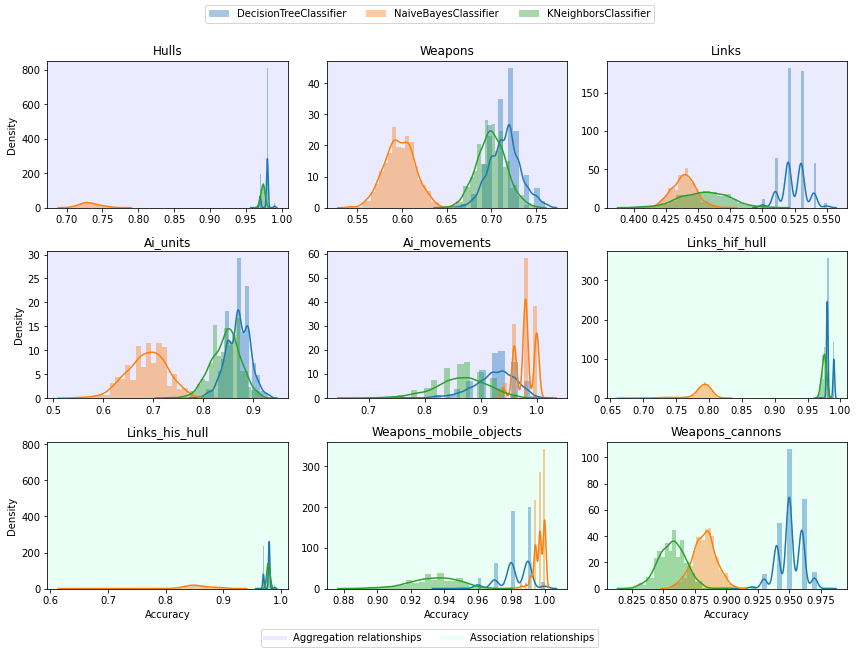

In [7]:
relationships = { "aggregation":
                    ["hulls", "links", "weapons", "ai_units", "ai_movements"],
                  "association":
                    ["links_hif_hull", "links_his_hull", "weapons_mobile_objects", "weapons_cannons"]
                }

fig, axs = plt.subplots(3, 3, figsize=(12,9))
rows = [0, 0, 0, 1, 1, 1, 2, 2, 2]

for i, key in enumerate(datasets.keys()):
    ### Aggregation relationships
    if "hulls" == key:
        fieldnames = ["ScaleX", "ScaleY", "ScaleZ",
                      "PositionX", "PositionY", "PositionZ",
                      "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                      "ObjectMass", "ObjectMaximumLife", "ObjectArmor",
                      "DestructionDelay", "EffectMultiplierKill", "EffectMultiplierDestroy",
                      "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ"]
    elif "links" == key:
        fieldnames = ["DestructionDelay", "EffectMultiplierKill", "EffectMultiplierDestroy"]
    elif "weapons" == key:
        fieldnames = ["ScaleX", "ScaleY", "ScaleZ",
                      "PositionX", "PositionY", "PositionZ",
                      "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                      "ObjectMass", "ObjectMaximumLife", "ObjectArmor",
                      "DestructionDelay", "EffectMultiplierKill", "EffectMultiplierDestroy",
                      "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ",
                      "ReloadTime", "AffectorScaleFactor", "AffectorPowerFactor",
                      "AffectorPositionX", "AffectorPositionY", "AffectorPositionZ"]
    elif "ai_units" == key:
        fieldnames = ["AIBehaviourDistance", "AIAttackSpeed"]
    elif "ai_movements" == key:
        fieldnames = ["Acceleration", "MinimumSpeed", "MaximumSpeed",
                      "ReachDestinationAtFullLinearSpeed", "AccelerationAngular",
                      "MaximumSpeedAngular", "ReachDestinationAtFullAngularSpeed"]
    ### Assocation relationships
    elif "links_hif_hull" == key:
        fieldnames = ["ScaleX", "ScaleY", "ScaleZ",
                      "PositionX", "PositionY", "PositionZ",
                      "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                      "ObjectMass", "ObjectMaximumLife", "ObjectArmor",
                      "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ"]
    elif "links_his_hull" == key:
        fieldnames = ["ScaleX", "ScaleY", "ScaleZ",
                      "PositionX", "PositionY", "PositionZ",
                      "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                      "ObjectMass", "ObjectMaximumLife", "ObjectArmor",
                      "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ"]
    elif "weapons_mobile_objects" == key:
        fieldnames = ["ScaleX", "ScaleY", "ScaleZ", "PositionX", "PositionY", "PositionZ",
                      "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                      "ObjectMass", "ObjectMaximumLife", "ObjectArmor",
                      "DestructionDelay", "EffectMultiplierKill", "EffectMultiplierDestroy",
                      "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ",
                      "ReloadTime", "AffectorScaleFactor", "AffectorPowerFactor",
                      "AffectorPositionX", "AffectorPositionY", "AffectorPositionZ",
                      "LocalPositionX", "LocalPositionY", "LocalPositionZ"]
    elif "weapons_cannons" == key:
        fieldnames = ["ScaleX", "ScaleY", "ScaleZ", "PositionX", "PositionY", "PositionZ",
                      "OrientationW", "OrientationX", "OrientationY", "OrientationZ",
                      "ObjectMass", "ObjectMaximumLife", "ObjectArmor",
                      "DestructionDelay", "EffectMultiplierKill", "EffectMultiplierDestroy",
                      "LocalDirectionX", "LocalDirectionY", "LocalDirectionZ",
                      "ReloadTime", "AffectorScaleFactor", "AffectorPowerFactor",
                      "AffectorPositionX", "AffectorPositionY", "AffectorPositionZ",
                      "FiringTurnMaximum", "FiringTurnStart", "FiringTurnEnd", "Roll",
                      "FiringPositionX", "FiringPositionY", "FiringPositionZ",
                      "FiringDirectionX", "FiringDirectionY", "FiringDirectionZ"]
    
    if any(ele == key for ele in relationships["aggregation"]):
        rel = "aggregation"
    elif any(ele == key for ele in relationships["association"]):
        rel = "association"
    
    print(f"### {key}_mut.csv ###\n")
    model_data = pd.read_csv(f"{path_out}/datasets/{rel}/mutated/{key}_mut.csv")

    all_inputs = model_data[fieldnames].values
    all_classes = model_data["Name"].values
    
    print(all_inputs[:5], end='\n\n')
    print(f"Classes: {all_classes}", end='\n\n')
    
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.80, random_state=456)

    print(f"Training set: {training_inputs.shape}")
    print(f"Testing set: {testing_inputs.shape}", end='\n\n')
    
    ### DecisionTreeClassifier ###
    # Create the classifier.
    decision_tree_classifier = DecisionTreeClassifier()
    # Train the classifier on the training set.
    decision_tree_classifier.fit(training_inputs, training_classes)
    # Validate the classifier on the testing set using classification accuracy.
    print("DecisionTreeClassifier")
    print(decision_tree_classifier.score(testing_inputs, testing_classes))
    print(decision_tree_classifier.predict(testing_inputs[:1, :]), end='\n\n')

    ### Model accuracies ###
    axs[rows[i], i % 3].set_title(key.capitalize())
    if rel == "aggregation":
        axs[rows[i], i % 3].patch.set_facecolor("#eaebff")
    if rel == "association":
        axs[rows[i], i % 3].patch.set_facecolor("#eafff5")
    
    # DecisionTreeClassifier
    model_accuracies = []
    for repetition in range(1000):
        (training_inputs,
         testing_inputs,
         training_classes,
         testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.75)

        classifier = DecisionTreeClassifier()
        classifier.fit(training_inputs, training_classes)
        
        classifier_accuracy = classifier.score(testing_inputs, testing_classes)
        model_accuracies.append(round(classifier_accuracy, 2))
    sb.distplot(model_accuracies, label="DecisionTreeClassifier", ax=axs[rows[i], i % 3])
    # NaiveBayesClassifier
    model_accuracies = []
    for repetition in range(1000):
        (training_inputs,
         testing_inputs,
         training_classes,
         testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.75)

        classifier = GaussianNB()
        classifier.fit(training_inputs, training_classes)
        classifier_accuracy = classifier.score(testing_inputs, testing_classes)
        model_accuracies.append(classifier_accuracy)
    sb.distplot(model_accuracies, label="NaiveBayesClassifier", ax=axs[rows[i], i % 3])
    # KNeighborsClassifier
    model_accuracies = []
    for repetition in range(1000):
        (training_inputs,
         testing_inputs,
         training_classes,
         testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.75)

        classifier = KNeighborsClassifier(3)
        classifier.fit(training_inputs, training_classes)
        classifier_accuracy = classifier.score(testing_inputs, testing_classes)
        model_accuracies.append(classifier_accuracy)
    sb.distplot(model_accuracies, label="KNeighborsClassifier", ax=axs[rows[i], i % 3])

# Stack x-y labels.
k = 0
for ax in axs.flat:
    if k != 0 and k != 3 and k != 6:
        ax.set(ylabel="")
    if k > 5:
        ax.set(xlabel="Accuracy")
    k += 1

# Fit subplots within figure cleanly.
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Compose figure legends.
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3)
fig.legend([Line2D([0], [0], color="#eaebff", lw=4),
            Line2D([0], [0], color="#eafff5", lw=4)],
           ['Aggregation relationships', 'Association relationships'],
           loc="lower center", ncol=2)

# Save the figure as a PDF file.
fig.savefig(f"{path_out}/plots/model_accuracies.pdf")
#plt.close("all")